In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8, 4]

# [MNIST](http://yann.lecun.com/exdb/mnist/)

## hosted by Yann LeCun

THE MNIST DATABASE of handwritten digits

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [16]:
mnist.train.num_examples

55000

In [17]:
mnist.test.num_examples

10000

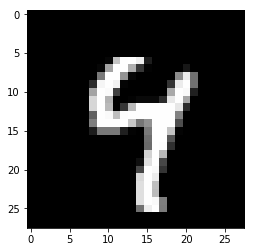

4

In [21]:
plt.imshow(np.reshape(train_data[2], [28, 28]), cmap='gray')
plt.show()
train_labels[2]

- 숫자 이미지 하나의 크기는 $28 \times 28$
- Gray scale

In [30]:
train_data[2][170:190]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02352941, 0.76470596,
       0.9960785 , 1.        , 0.93725497, 0.1137255 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [11]:
# inspired by CNN model from https://www.tensorflow.org/tutorials/layers

def dnn_model_fn(features, labels, mode):
    input_layer = features["x"]
      
    hidden1 = tf.layers.dense(inputs=input_layer, units=1024, activation=tf.nn.relu)
    hidden2 = tf.layers.dense(inputs=hidden1, units=512, activation=tf.nn.relu)
    hidden3 = tf.layers.dense(inputs=hidden2, units=1024, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=hidden3, units=10)  # activation = None => linear

    predictions = {"classes": tf.argmax(input=logits, axis=1),
                   "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [12]:
mnist_classifier = tf.estimator.Estimator(model_fn=dnn_model_fn, model_dir="mnist_dnn_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist_dnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000029E8060E128>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
logging_hook = tf.train.LoggingTensorHook(tensors={}, at_end=True)

train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},
                                                    y=train_labels,
                                                    batch_size=100,
                                                    num_epochs=None,
                                                    shuffle=True)
mnist_classifier.train(input_fn=train_input_fn,
                       steps=2000,
                       hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into mnist_dnn_model\model.ckpt.
INFO:tensorflow:loss = 2.2974925, step = 1
INFO:tensorflow:global_step/sec: 52.9655
INFO:tensorflow:loss = 0.33663505, step = 101 (1.889 sec)
INFO:tensorflow:global_step/sec: 57.3184
INFO:tensorflow:loss = 0.14119, step = 201 (1.745 sec)
INFO:tensorflow:global_step/sec: 58.4265
INFO:tensorflow:loss = 0.10976124, step = 301 (1.712 sec)
INFO:tensorflow:global_step/sec: 58.4196
INFO:tensorflow:loss = 0.13133138, step = 401 (1.712 sec)
INFO:tensorflow:global_step/sec: 57.1542
INFO:tensorflow:loss = 0.078569084, step = 501 (1.751 sec)
INFO:tensorflow:global_step/sec: 57.3844
INFO:tensorflow:loss = 0.068996586, step = 601 (1.742 sec)
INFO:tensorflow:global_step/sec: 58.3923
INFO:tensorflow:loss = 0.09850408, step = 701 (1.713 sec)
INFO:tensorflow:global_step/sec: 57.4836
INFO:tensorflow:loss = 0.0218405, step = 801 (1.740 sec)
INFO:tensorflow:global_step/sec: 57.0888
INFO:ten

In [14]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": eval_data},
                                                   y=eval_labels,
                                                   num_epochs=1,
                                                   shuffle=False)
mnist_classifier.evaluate(input_fn=eval_input_fn)

INFO:tensorflow:Starting evaluation at 2018-02-20-05:14:07
INFO:tensorflow:Restoring parameters from mnist_dnn_model\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-02-20-05:14:08
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9707, global_step = 2000, loss = 0.102792345


{'accuracy': 0.9707, 'global_step': 2000, 'loss': 0.102792345}

INFO:tensorflow:Restoring parameters from mnist_dnn_model\model.ckpt-2000


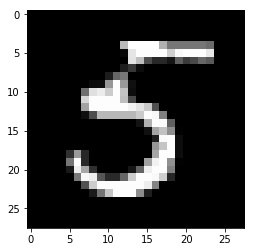

Model prediction: {'classes': 5, 'probabilities': array([7.2970062e-16, 6.8497508e-13, 5.0366680e-15, 2.0861239e-07,
       3.8190886e-14, 9.9999976e-01, 1.5875076e-12, 9.7814359e-16,
       1.0813485e-11, 3.8759623e-10], dtype=float32)}


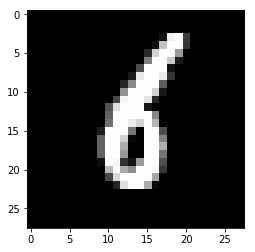

Model prediction: {'classes': 6, 'probabilities': array([1.9027572e-04, 2.9293931e-05, 2.1855960e-05, 1.3701654e-05,
       3.0326017e-04, 1.0344718e-02, 9.8853743e-01, 4.4395600e-07,
       5.5391056e-04, 5.2106639e-06], dtype=float32)}


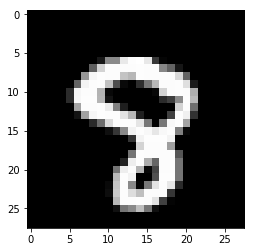

Model prediction: {'classes': 8, 'probabilities': array([9.2467316e-04, 1.6559949e-04, 1.4983612e-03, 8.5427528e-03,
       6.3331593e-03, 4.3553405e-02, 1.2978340e-03, 5.1669439e-04,
       8.8014513e-01, 5.7022456e-02], dtype=float32)}


In [15]:
test_images = eval_data[np.random.choice(mnist.test.num_examples, 3)]
input_fn = tf.estimator.inputs.numpy_input_fn(x={'x': test_images}, shuffle=False)
preds = list(mnist_classifier.predict(input_fn))

for i in range(3):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])